In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [28]:
%matplotlib inline
cleaned_obs = pd.read_csv("clean.csv")
cleaned_obs.head()

,id,subjid,sex,agedays,param,measurement,clean_value
0,1,46663895,0,2970,HEIGHTCM,121.920000,Include
1,2,46663895,0,3776,HEIGHTCM,152.400000,Include
2,3,46663895,0,2970,WEIGHTKG,24.494239,Include
3,4,46663895,0,3776,WEIGHTKG,40.823732,Include
4,5,46668331,0,2959,HEIGHTCM,116.840000,Include


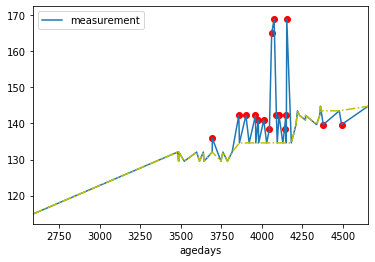

In [3]:
individual = cleaned_obs[cleaned_obs.subjid == 47085108]
heights = individual[individual.param == 'HEIGHTCM']
sorted_heights = heights.sort_values('agedays')
excluded_heights = sorted_heights[sorted_heights.clean_value != 'Include']
included_heights = sorted_heights[sorted_heights.clean_value == 'Include']
height_plot = sorted_heights.plot.line(x='agedays', y='measurement')
height_plot.plot(included_heights['agedays'], included_heights['measurement'], c='y', linestyle='-.')
height_plot.scatter(x=excluded_heights.agedays, y=excluded_heights.measurement, c='r')

In [29]:
cleaned_obs['clean_cat'] = cleaned_obs['clean_value'].astype('category')
cleaned_obs.loc[cleaned_obs.param == 'WEIGHTKG'].clean_cat.value_counts()

Include                                    42952
Exclude-EWMA-Extreme                         211
Exclude-SD-Cutoff                            165
Exclude-EWMA-8                               154
Exclude-EWMA-9                               101
Exclude-Too-Many-Errors-Other-Parameter       77
Exclude-Carried-Forward                       72
Exclude-Too-Many-Errors                       63
Exclude-EWMA-Extreme-Pair                     59
Exclude-Single-Outlier                        58
Exclude-EWMA-11                               13
Exclude-Pair-Delta-17                          9
Exclude-Pair-Delta-18                          5
Exclude-EWMA-12                                1
Exclude-Min-Height-Change                      0
Exclude-EWMA-13                                0
Exclude-Max-Height-Change                      0
Name: clean_cat, dtype: int64

In [30]:
cleaned_obs['age'] = cleaned_obs['agedays'] / 365
cleaned_obs['include'] = cleaned_obs.clean_value.eq("Include")

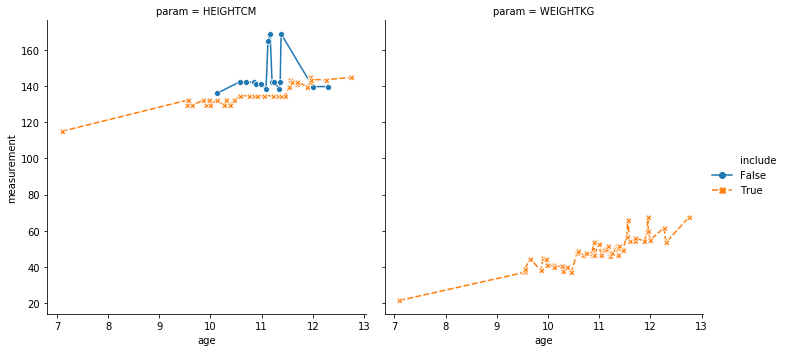

In [39]:
import seaborn as sns
individual = cleaned_obs[cleaned_obs.subjid == 47085108]
sns.relplot(x='age', y='measurement', col='param', hue='include', style='include', 
            kind='line', markers=True, data=individual)

In [31]:
cleaned_obs['height'] = np.where(cleaned_obs['param'] == 'HEIGHTCM', cleaned_obs['measurement'], np.NaN)
cleaned_obs['weight'] = np.where(cleaned_obs['param'] == 'WEIGHTKG', cleaned_obs['measurement'], np.NaN)
heights = cleaned_obs[cleaned_obs.param == 'HEIGHTCM'] 
weights = cleaned_obs[cleaned_obs.param == 'WEIGHTKG']
merged = heights.merge(weights, on=['subjid', 'agedays', 'sex'], how='outer')
only_needed_columns = merged.drop(columns=['param_x', 'measurement_x', 'clean_value_x', 'age_x', 'weight_x', 
                     'id_y', 'param_y', 'measurement_y', 'clean_value_y', 'height_y'])
clean_column_names = only_needed_columns.rename(columns={'clean_cat_x': 'height_cat', 'include_x': 'include_height',
                                                        'height_x': 'height', 'clean_cat_y': 'weight_cat',
                                                        'age_y': 'age', 'include_y': 'include_weight', 
                                                         'weight_y': 'weight'})
clean_column_names['bmi'] = clean_column_names['weight'] / ((clean_column_names['height'] / 100) ** 2)
individual = clean_column_names[clean_column_names.subjid == 47085108]

In [22]:
bmi_percentiles = pd.read_csv("bmiagerev.csv")
bmi_percentiles['Agemos'] = pd.to_numeric(bmi_percentiles['Agemos'], errors='coerce')
bmi_percentiles['P5'] = pd.to_numeric(bmi_percentiles['P5'], errors='coerce')
bmi_percentiles['P95'] = pd.to_numeric(bmi_percentiles['P95'], errors='coerce')
bmi_percentiles['age'] = bmi_percentiles['Agemos'] / 12

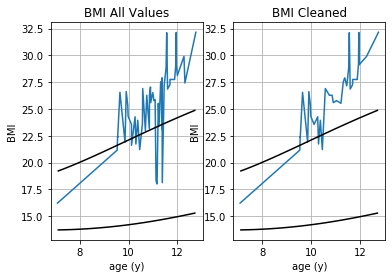

In [10]:
fig, ax = plt.subplots(1, 2)
percentile_window = bmi_percentiles.loc[(bmi_percentiles.Sex == '1') & 
                                        (bmi_percentiles.age > individual.age.min()) &
                                        (bmi_percentiles.age < individual.age.max())]
ax[0].plot(individual.age, individual.bmi)
ax[0].plot(percentile_window.age, percentile_window.P5, color='k')
ax[0].plot(percentile_window.age, percentile_window.P95, color='k')

ax[0].set(xlabel='age (y)', ylabel='BMI',
       title='BMI All Values')
ax[0].grid()

ax[1].plot(individual[individual.include_height & individual.include_weight].age, individual.loc[individual.include_height & individual.include_weight].bmi)
ax[1].plot(percentile_window.age, percentile_window.P5, color='k')
ax[1].plot(percentile_window.age, percentile_window.P95, color='k')

ax[1].set(xlabel='age (y)', ylabel='BMI',
       title='BMI Cleaned')
ax[1].grid()

plt.show()

In [13]:
clean_column_names['rounded_age'] = np.around(clean_column_names.age)

In [26]:
clean_column_names.groupby(['rounded_age', 'sex'])['bmi'].agg(['min', 'mean', 'max', 'std', 'count'])

NameError: name 'clean_column_names' is not defined

In [20]:
clean_column_names[clean_column_names.include_height & 
                   clean_column_names.include_weight].groupby(['rounded_age', 
                                                               'sex'])['bmi'].agg(['min', 'mean', 'max', 'std', 'count'])

min       mean        max       std  count
rounded_age sex                                                  
2.0         0    12.644709  16.986908  24.533442  1.678010    730
            1    12.137937  16.840102  29.001918  1.908187    699
3.0         0    11.764304  16.617985  33.995533  1.874353   1626
            1    11.082464  16.466415  30.949620  1.922066   1376
4.0         0    11.609011  16.376245  35.472695  1.967082   1803
            1    11.727191  16.364206  31.618663  2.263351   1667
5.0         0     9.737906  16.402471  35.647171  2.233655   2101
            1    11.420878  16.426136  30.236289  2.505720   1716
6.0         0    11.695795  16.673196  33.030976  2.656045   2000
            1    11.319471  16.729285  31.850433  2.917888   1614
7.0         0    12.382569  17.160103  34.788431  3.348000   1886
            1    11.284847  17.460115  39.331337  3.640476   1548
8.0         0     8.209614  17.784316  48.222025  3.817509   2118
            1    10.312989  18.347128  48.182637  4.138108   1628
9.0         0     6.468307  18.465295  39.325535  4.164382   2288
            1    11.717651  19.464742  48.182637  4.706637   1839
10.0        0    12.537721  19.399572  54.493947  4.653058   2300
            1    11.396007  20.088414  42.370780  4.997035   1828
11.0        0    12.297545  20.056993  48.924160  4.922905   1851
            1    11.485480  20.774305  43.880710  5.258744   1451
12.0        0    12.958007  20.960576  47.583079  5.392719   1280
            1    11.882579  21.417713  43.481669  5.629028   1028
13.0        0    13.168724  21.257355  45.054309  5.185623    838
            1    11.573086  22.260672  43.959893  5.408547    629
14.0        0    14.229923  22.586208  46.919615  5.744018    660
            1    12.572715  22.741073  51.670520  5.569740    482
15.0        0    13.835323  22.796602  54.055313  5.312129    369
            1    13.697996  22.930595  56.652882  5.200888    243
16.0        0    15.860994  23.623772  53.217318  6.458629    159
            1    13.547213  24.881489  44.358372  5.830226    155
17.0        0    17.357996  24.797843  46.868080  5.917198     76
            1    14.953851  26.349107  59.073945  9.122283     70
18.0        0    18.485741  26.273522  45.704904  6.479697     43
            1    14.364976  26.287699  58.347169  9.414829     34
19.0        0    15.818836  26.863054  41.068820  6.848116     17
            1    17.534926  29.207248  48.866108  9.823126      9
20.0        0    20.254654  30.759828  39.738408  8.723529      5
            1    35.705457  35.705457  35.705457       NaN      1

In [10]:
import charts

In [12]:
obs = charts.setup_individual_obs_df(cleaned_obs)

In [13]:
interactive(charts.overlap_view, obs_df=fixed(obs), subjid=[47085108, 46663895, 46793195, 47058401], param=['HEIGHTCM', 'WEIGHTKG'])

interactive(children=(Dropdown(description='subjid', options=(47085108, 46663895, 46793195, 47058401), value=4…

In [19]:
uniq_ids = cleaned_obs['subjid'].unique()
sample = np.random.choice(uniq_ids, size=16)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

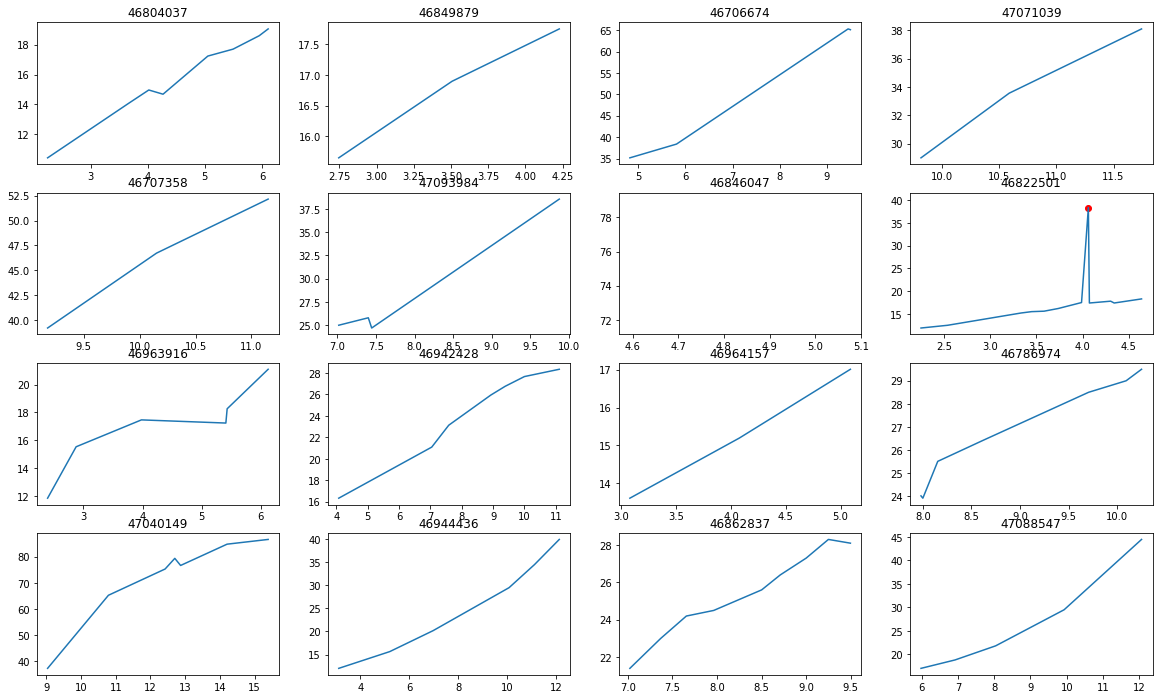

In [25]:
charts.four_by_four_view(cleaned_obs, sample, 'WEIGHTKG')

In [23]:
bmi_percentiles.head()

,Sex,Agemos,L,M,S,P3,P5,P10,P25,P50,P75,P85,P90,P95,P97,age
0,1,24.0,-2.01118107,16.57502768,0.080592465,14.52095333,14.737319,15.09032827,15.74164233,16.57502768,17.55718781,18.16219473,18.60948128,19.338011,19.85985812,2.000000
1,1,24.5,-1.982373595,16.54777487,0.080127429,14.50347667,14.719293,15.07117474,15.71962876,16.54777487,17.52129279,18.11954923,18.56110634,19.278898,19.79194014,2.041667
2,1,25.5,-1.924100169,16.49442763,0.079233994,14.46882381,14.683608,15.03335725,15.67634464,16.49442763,17.45135039,18.03668013,18.46729593,19.164660,19.66102345,2.125000
3,1,26.5,-1.86549793,16.44259552,0.078389356,14.43459737,14.648433,14.99619505,15.634035,16.44259552,17.38383656,17.95700228,18.37736191,19.055674,19.5365754,2.208333
4,1,27.5,-1.807261899,16.3922434,0.077593501,14.40082828,14.613786,14.95969047,15.5926798,16.3922434,17.3187102,17.88047101,18.29125345,18.951867,19.41848805,2.291667


In [24]:
bmi_percentiles.Sex.dtype

dtype('O')

In [34]:
gb = clean_column_names[clean_column_names.include_height & 
                   clean_column_names.include_weight].groupby(['rounded_age', 
                                                               'sex'])['bmi'].agg(['min', 'mean', 'max', 'std', 'count'])

In [33]:
clean_column_names['rounded_age'] = np.around(clean_column_names.age)

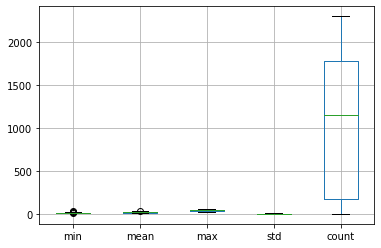

In [35]:
gb.boxplot()

In [37]:
gb.index

MultiIndex([( 2.0, 0),
            ( 2.0, 1),
            ( 3.0, 0),
            ( 3.0, 1),
            ( 4.0, 0),
            ( 4.0, 1),
            ( 5.0, 0),
            ( 5.0, 1),
            ( 6.0, 0),
            ( 6.0, 1),
            ( 7.0, 0),
            ( 7.0, 1),
            ( 8.0, 0),
            ( 8.0, 1),
            ( 9.0, 0),
            ( 9.0, 1),
            (10.0, 0),
            (10.0, 1),
            (11.0, 0),
            (11.0, 1),
            (12.0, 0),
            (12.0, 1),
            (13.0, 0),
            (13.0, 1),
            (14.0, 0),
            (14.0, 1),
            (15.0, 0),
            (15.0, 1),
            (16.0, 0),
            (16.0, 1),
            (17.0, 0),
            (17.0, 1),
            (18.0, 0),
            (18.0, 1),
            (19.0, 0),
            (19.0, 1),
            (20.0, 0),
            (20.0, 1)],
           names=['rounded_age', 'sex'])

In [42]:
clean_column_names['include_both'] = clean_column_names['include_height'] & clean_column_names['include_weight']

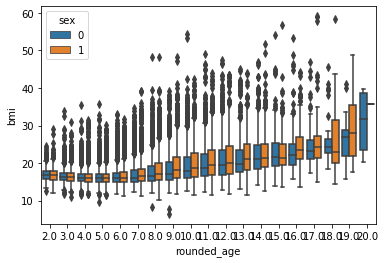

In [43]:
sns.boxplot(x='rounded_age', y='bmi', hue='sex', data=clean_column_names[clean_column_names['include_both'] == True])

In [47]:
charts.bmi_stats(clean_column_names)

AttributeError: module 'charts' has no attribute 'bmi_stats'

In [45]:
%load_ext autoreload

In [46]:
%autoreload 2

In [50]:
charts.bmi_stats(clean_column_names)

AttributeError: module 'charts' has no attribute 'bmi_stats'

In [49]:
import charts